In [38]:
# ilibraries import
import yfinance as yf 
import pandas as pd
import holidays
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import minimize 
import warnings
warnings.filterwarnings("ignore")

In [60]:
#downloading data
stock = ["AAPL", "GOOGL", "TSLA", "MSFT"]
data = yf.download(stock, start="2022-01-01", end="2025-01-01")
data = data[["Close", "Open", "Volume"]]
data = data.stack(level=1).reset_index() #Multi-index to single index
data.columns = ["Date", "Ticker", "Close", "Open", "Volume"]
data["Date"] = pd.to_datetime(data["Date"])#check if dates are datetime

[*********************100%***********************]  4 of 4 completed


In [61]:
holiday = holidays.US(years=range(2022, 2025)) #retrieve holidays days in the US between 2022 and 2025
dataf = pd.DataFrame(list(holiday.items()), columns=["Date", "holiday"])
dataf.set_index("Date", inplace=True)
dataf.index = pd.to_datetime(dataf.index)

#merge Ferie dataframe and market dataframe
data = pd.merge(data, dataf, how="left", on="Date")
data["holiday"] = data["holiday"].isna()
data = data[data["holiday"] == True] #sort holidays in the dataframe

data.head()

,Date,Ticker,Close,Open,Volume,holiday
0,2022-01-03,AAPL,178.443146,174.345068,104487900,True
1,2022-01-03,GOOGL,143.998337,144.061394,28646000,True
2,2022-01-03,MSFT,324.504547,325.086189,28865100,True
3,2022-01-03,TSLA,399.926666,382.583344,103931400,True
4,2022-01-04,AAPL,176.178391,179.050979,99310400,True


In [64]:
#add metrics to the dataframe
data["Return"] = data.groupby("Ticker")["Close"].pct_change()
data["log_return"] = np.log(data["Close"]/data.groupby("Ticker")["Close"].shift(1))
data["cum_return"] = data.groupby("Ticker")["Return"].transform(lambda x: (1+x).cumprod())
data["annual_std"] = data.groupby("Ticker")["Return"].transform(lambda x: x.rolling(window = 30).std()*np.sqrt(252))
data.dropna()

,Date,Ticker,Close,Open,Volume,holiday,Return,log_return,cum_return,annual_std
120,2022-02-15,AAPL,169.619659,167.833060,62527400,True,0.023152,0.022888,0.950553,0.306395
121,2022-02-15,GOOGL,135.672760,136.628161,26680000,True,0.007987,0.007956,0.942183,0.378187
122,2022-02-15,MSFT,291.273773,290.827860,27058300,True,0.018542,0.018373,0.897595,0.320761
123,2022-02-15,TSLA,307.476654,300.000000,57286200,True,0.053291,0.051919,0.768833,0.669344
124,2022-02-16,AAPL,169.384048,168.696895,61177400,True,-0.001389,-0.001390,0.949233,0.304557
...,...,...,...,...,...,...,...,...,...,...
3007,2024-12-30,TSLA,417.410004,419.399994,64941000,True,-0.033012,-0.033569,1.043716,0.598346
3008,2024-12-31,AAPL,249.534180,251.547039,39480700,True,-0.007058,-0.007083,1.398396,0.145739
3009,2024-12-31,GOOGL,188.684845,190.459059,17466900,True,-0.010144,-0.010196,1.310327,0.352046
3010,2024-12-31,MSFT,419.196564,423.771431,13246500,True,-0.007838,-0.007869,1.291805,0.184485


In [65]:
# Sharpe Ratio computation

def ratio_sharpe(group):
    mean_daily_return = group["Return"].mean()
    Annualised_return = (1 + mean_daily_return)**252 -1 
    daily_volatility = group["Return"].std()
    annualised_volatility = daily_volatility*np.sqrt(252)
    sharpe = (Annualised_return - 0.02)/annualised_volatility
    return sharpe

In [66]:
sharpe_ratios = data.groupby("Ticker").apply(ratio_sharpe)

print(sharpe_ratios)


Ticker
AAPL     0.522149
GOOGL    0.414737
MSFT     0.407857
TSLA     0.308741
dtype: float64


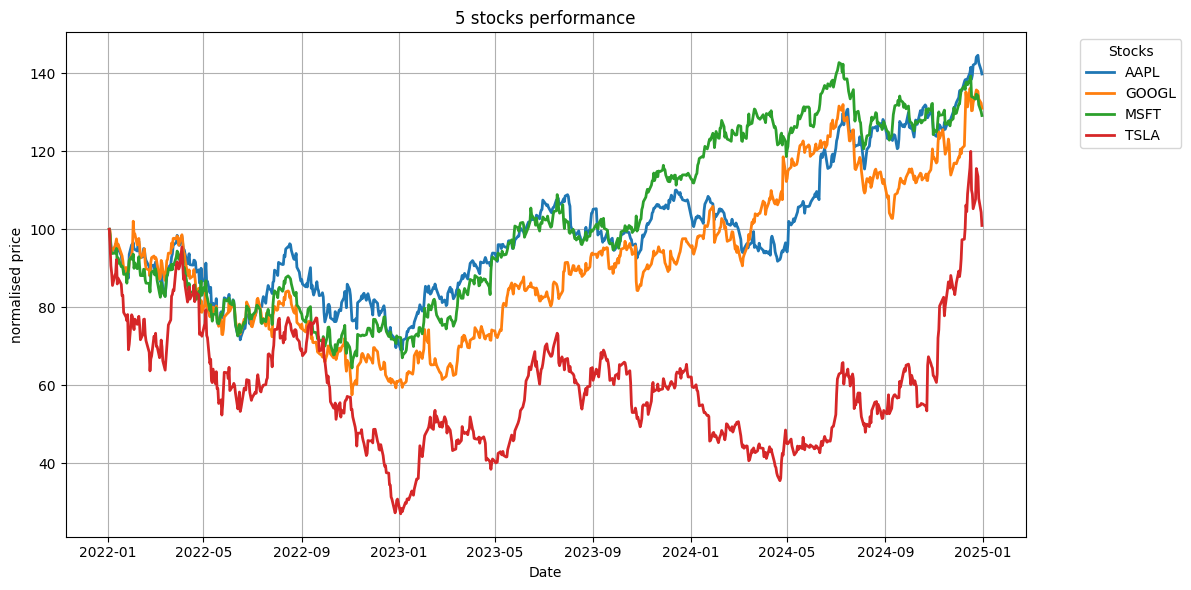

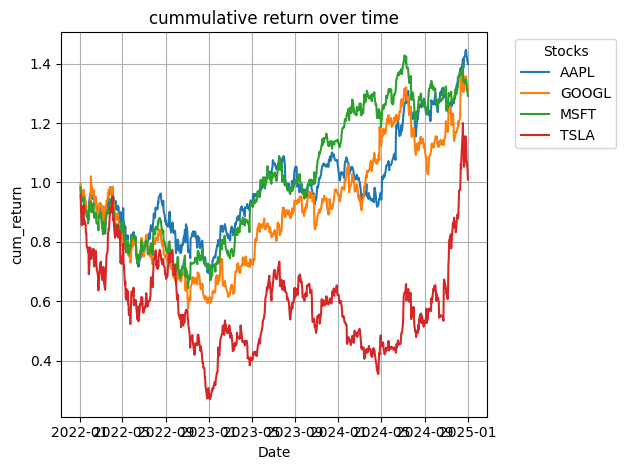

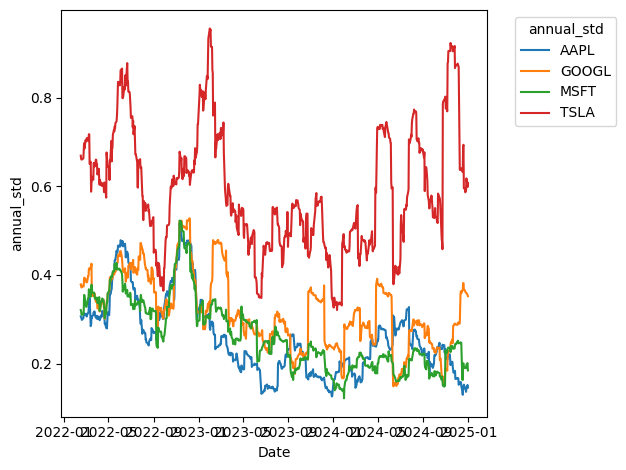

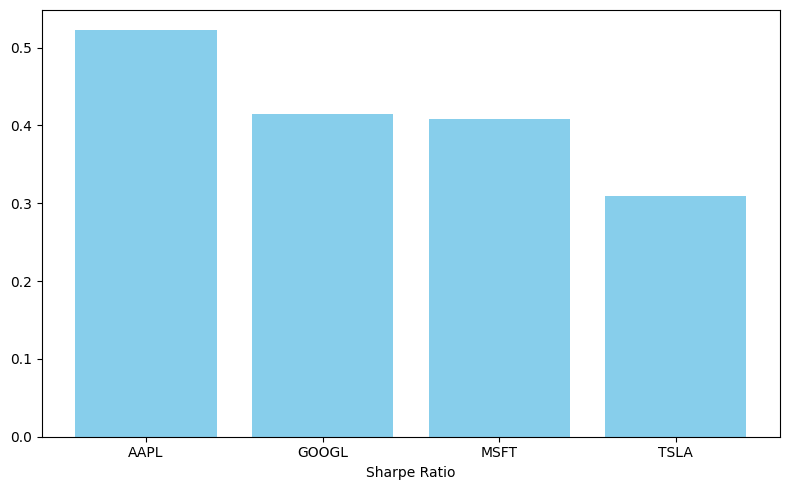

In [67]:
#Plotting 

data["Close_norm"] = data.groupby("Ticker")["Close"].transform(lambda x : (x/x.iloc[0])*100)

plt.figure(figsize=(12, 6))

for ticker, group in data.groupby('Ticker'):
    plt.plot(group['Date'], 
             group['Close_norm'], 
             label=ticker,  
             linewidth=2)


plt.legend(title='Stocks',
           bbox_to_anchor=(1.05, 1),  
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('normalised price') 
plt.title('5 stocks performance')
plt.grid(True)
plt.tight_layout()  
plt.show()

for ticker, group in data.groupby("Ticker"):
    plt.plot(group["Date"], group["cum_return"], label=ticker)

plt.legend(title = "Stocks", bbox_to_anchor = (1.05,1), loc ="upper left")
plt.xlabel("Date")
plt.ylabel("cum_return")
plt.title("cummulative return over time")
plt.grid(True)
plt.tight_layout()
plt.show()

for ticker, group in data.groupby("Ticker"):
    plt.plot(group["Date"], group["annual_std"], label=ticker)
plt.legend(title="annual_std", bbox_to_anchor =(1.05,1), loc="upper left")
plt.xlabel("Date")
plt.ylabel("annual_std")
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
plt.bar(sharpe_ratios.index, sharpe_ratios.values, color="skyblue")
plt.xlabel("Sharpe Ratio")
plt.tight_layout()
plt.show()




In [76]:
#Weight

Pond = []
r = 0
for i in range(len(stock)): 
    r = np.random.rand()
    Pond.append((r))
print(Pond)
somme_weight = np.sum(Pond)
Pond = Pond/somme_weight

portfolio = pd.DataFrame({"Weight": Pond}, index=stock)

ca_init = 100000

portfolio["Capital per stocks"] = portfolio["Weight"]*ca_init

print(portfolio)

[0.4720143253155674, 0.12366239259103406, 0.880498619986043, 0.5681024558306924]
         Weight  Capital per stocks
AAPL   0.230895        23089.539336
GOOGL  0.060492         6049.197079
TSLA   0.430714        43071.378200
MSFT   0.277899        27789.885385


In [69]:
def Rendport(group1, group2): 
    somme = 0
    for ticker, group in group1.groupby("Ticker"): 
        somme = somme + group["cum_return"].mean()*group2.loc[ticker, "Weight"]
    return somme

print(f'The portfolio return is {Rendport(data, portfolio)}')

The portfolio return is 0.8310526381117695


In [75]:
#Sharpe Ratio Optimization 

returns = (data
           .pivot(index="Date", columns="Ticker", values="Return")
           .dropna())

mu  = returns.mean().values          
cov = returns.cov().values
rf = 0.02
def neg_sharpe(w, mu, cov, rf):
    port_ret = np.dot(w, mu) * 252
    port_vol = np.sqrt(w @ cov @ w *252)
    return -(port_ret - 0.02) / port_vol   

n = len(mu)
x0 = np.full(n, 1/n)                
bounds      = [(0, 1)] * n           
constraints = {'type': 'eq', 'fun': lambda w: w.sum() - 1}

opt = minimize(neg_sharpe, x0,
               args=(mu, cov, rf),
               bounds=bounds,
               constraints=constraints)

w_opt = opt.x 

In [74]:
#résults

port_ret = np.dot(w_opt, mu) * 252
port_vol = np.sqrt(w_opt @ cov @ w_opt * 252)
sharpe   = (port_ret - rf) / port_vol

print("=== optimum Weights ===")
for t, w in zip(returns.columns, w_opt):
    print(f"{t:5s} : {w:6.2%}")

print(f"Annual return waited : {port_ret:6.2%}")
print(f"Annual volatility     : {port_vol:6.2%}")
print(f"Shape ratio          : {sharpe:6.2f}")

=== optimum Weights ===
AAPL  : 72.09%
GOOGL : 18.88%
MSFT  :  6.41%
TSLA  :  2.63%
Annual return waited : 14.86%
Annual volatility     : 26.15%
Shape ratio          :   0.49
